## FlowerDataset 102クラスの分類<br><br>EfficientNet

In [2]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as T
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
from glob import glob

C:\Users\PC_User\anaconda3\envs\new_gpu_env\Lib\site-packages\albumentations\__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.7' (you have '2.0.6'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
import timm.loss as tl
print(dir(tl))

['AsymmetricLossMultiLabel', 'AsymmetricLossSingleLabel', 'BinaryCrossEntropy', 'JsdCrossEntropy', 'LabelSmoothingCrossEntropy', 'SoftTargetCrossEntropy', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', 'asymmetric_loss', 'binary_cross_entropy', 'cross_entropy', 'jsd']


In [4]:
os.environ["PYTHONHASHSEED"] = "42"

def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)

In [5]:
def images_with_labels(data_type: str):
    data_dirs = [fr"C:\Users\PC_User\Python\Kaggle\Flower_Classification\{data_type}\{i+1}" for i in range(102)]
    images_with_labels = [(img_path, class_id + 1) 
                          for class_id, class_dir in enumerate(data_dirs)
                          for img_path in glob(os.path.join(class_dir, "*.jpg"))]
    return images_with_labels

In [6]:
common_transform = [
    A.Resize(height=224, width=224),  # Fixed input size
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),  # ImageNet stats
    ToTensorV2()
]

train_transform = A.Compose([
    A.RandomRotate90(p=0.5),
    A.HorizontalFlip(p=0.5),
    *common_transform
])

val_transform = A.Compose([*common_transform])

class FlowerDataset(Dataset):
    def __init__(self, image_label_pairs, transform=None):
        self.image_label_pairs = image_label_pairs  # (image_path, label)
        self.transform = transform

    def __len__(self):
        return len(self.image_label_pairs)

    def __getitem__(self, idx):
        image_path, label = self.image_label_pairs[idx]
        image = np.array(Image.open(image_path).convert('RGB'))

        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']

        return image.float(), torch.tensor(label).long()

In [7]:
train_dataset = FlowerDataset(images_with_labels("train"), transform=train_transform)
val_dataset = FlowerDataset(images_with_labels("valid"), transform=val_transform)
test_dataset = FlowerDataset(images_with_labels("test"), transform=val_transform)

In [8]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## 最初のバッチの画像を見てみる

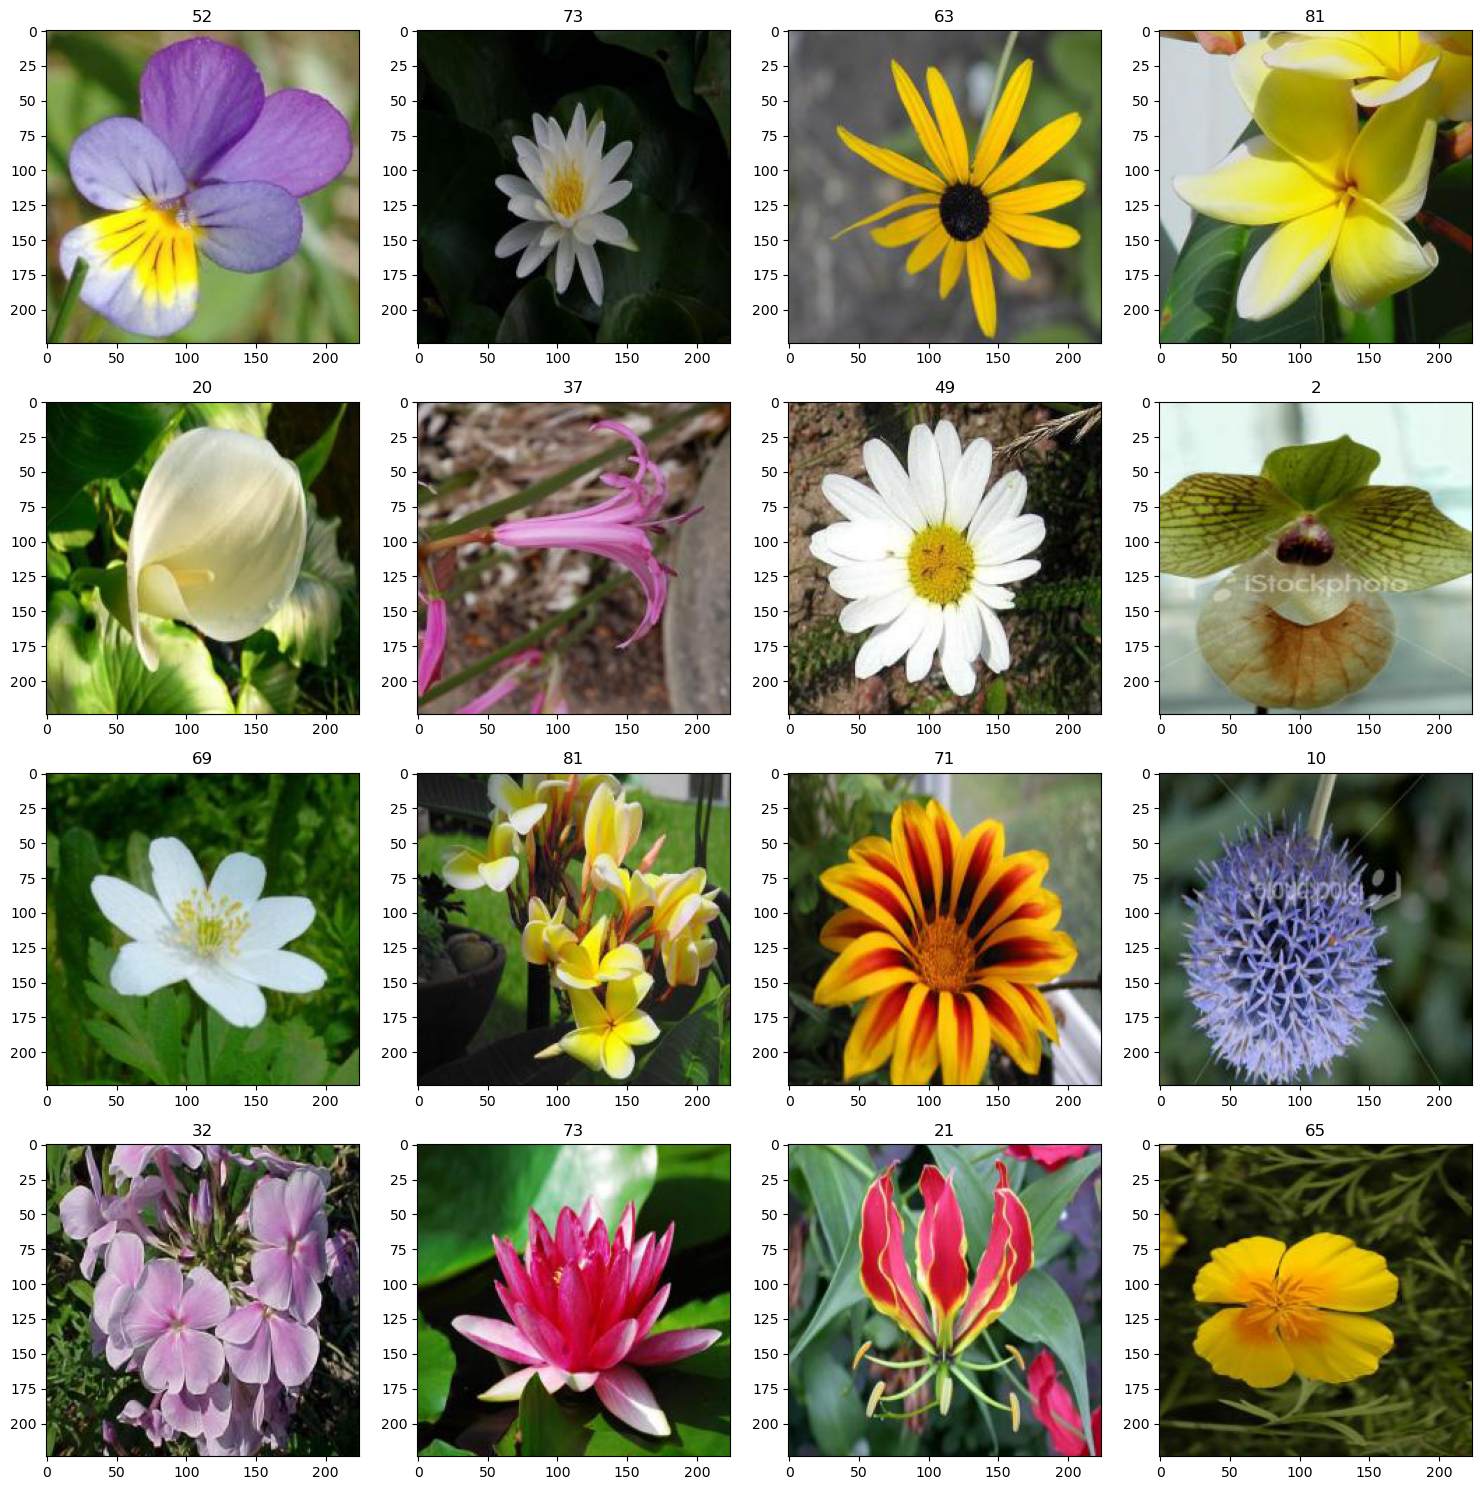

In [10]:
def denormalize(img, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):
    mean = torch.tensor(mean).view(-1, 1, 1).to(img.device)
    std = torch.tensor(std).view(-1, 1, 1).to(img.device)
    return img * std + mean

def show_image(image, label, ax):
    image = denormalize(image)
    image = torch.clamp(image, 0, 1)
    ax.imshow(image.permute(1, 2, 0).cpu().numpy())
    ax.set_title(f"{label}", fontsize=12)


fig, ax = plt.subplots(4, 4, figsize=(15, 15))
ax = ax.flatten()
for img_batch, label_batch in train_loader:
    for i in range(16):  
        img = img_batch[i]
        label = label_batch[i]
        show_image(img, label, ax[i])
    break
plt.tight_layout();

## 分類ヘッドを置き換え（出力数 = 102クラス）

In [12]:
import timm
model = timm.create_model('efficientnet_b0', pretrained=True)
model.classifier.out_features = 102
model = model.to('cuda')

## 訓練

In [14]:
def train_one_epoch(model, loader, optimizer, loss_fn):
    model.train()
    train_loss = 0
    for imgs, labels in loader:
        imgs, labels = imgs.to('cuda'), labels.to('cuda')
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    return train_loss / len(loader)

def validate_one_epoch(model, loader, loss_fn):
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to('cuda'), labels.to('cuda')
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)
            val_loss += loss.item()
    return val_loss / len(loader)

CrossEntropyLoss と AsymmetricLossSingleLabel で精度を比較する

In [16]:
def train(set_loss_type: int):
    if set_loss_type == 1:
        loss_fn = nn.CrossEntropyLoss()
    elif set_loss_type == 2:
        loss_fn = loss_fn = tl.AsymmetricLossSingleLabel()
    else:
        raise ValueError("Unsupported loss name")
        return

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2, factor=0.1)

    num_epochs = 30
    patience = 3
    patience_counter = 0
    best_val_loss = float('inf')
    history = {"train_loss": [], "val_loss": []}
    total_epochs = 0

    # 学習ループ
    for epoch in range(1, num_epochs + 1):
        total_epochs = epoch
        
        train_loss = train_one_epoch(model, train_loader, optimizer, loss_fn)
        val_loss = validate_one_epoch(model, val_loader, loss_fn)

        print(f"[{epoch:02d}] Train Loss: {train_loss:.5f} | Val Loss: {val_loss:.5f}")
        scheduler.step(val_loss)

        # ロス記録
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)

        # 最良モデルの保存
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()
            torch.save(best_model_state, f'best_model{set_loss_type}.pth')
            print(f"\nBest model saved with validation loss: {best_val_loss:.5f}\n")
            patience_counter = 0  # リセット
        else:
            patience_counter += 1

        # 早期終了
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

    plt.figure(figsize=(6, 3))
    plt.plot(np.arange(1, total_epochs+1), history["train_loss"], label='Train Loss')
    plt.plot(np.arange(1, total_epochs+1), history["val_loss"], label='Valid Loss')
    plt.legend(loc='upper right');

[01] Train Loss: 1.66810 | Val Loss: 0.57683

Best model saved with validation loss: 0.57683

[02] Train Loss: 0.29629 | Val Loss: 0.32211

Best model saved with validation loss: 0.32211

[03] Train Loss: 0.22689 | Val Loss: 0.34078
[04] Train Loss: 0.16331 | Val Loss: 0.29450

Best model saved with validation loss: 0.29450

[05] Train Loss: 0.16348 | Val Loss: 0.30053
[06] Train Loss: 0.11782 | Val Loss: 0.30309
[07] Train Loss: 0.11424 | Val Loss: 0.40404
Early stopping triggered.


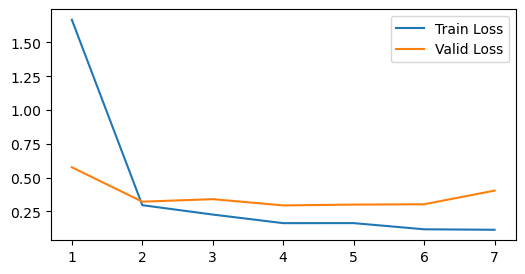

In [17]:
train(set_loss_type=1)

[01] Train Loss: 0.16775 | Val Loss: 0.36809

Best model saved with validation loss: 0.36809

[02] Train Loss: 0.11114 | Val Loss: 0.24498

Best model saved with validation loss: 0.24498

[03] Train Loss: 0.11197 | Val Loss: 0.30456
[04] Train Loss: 0.10592 | Val Loss: 0.29154
[05] Train Loss: 0.09941 | Val Loss: 0.22689

Best model saved with validation loss: 0.22689

[06] Train Loss: 0.06321 | Val Loss: 0.17796

Best model saved with validation loss: 0.17796

[07] Train Loss: 0.03962 | Val Loss: 0.25002
[08] Train Loss: 0.05817 | Val Loss: 0.26146
[09] Train Loss: 0.07303 | Val Loss: 0.26475
Early stopping triggered.


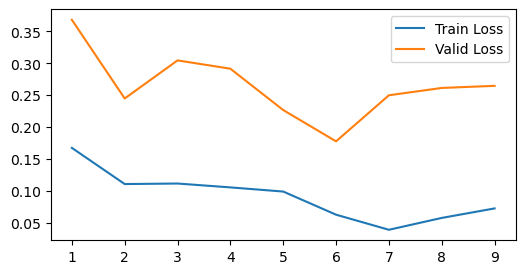

In [18]:
train(set_loss_type=2)

## Test

In [20]:
from sklearn.metrics import classification_report

def test(set_loss_type: int):
    if set_loss_type in [1, 2]:
        model = timm.create_model('efficientnet_b0', pretrained=False)
        model.classifier.out_features = 102
        model = model.to('cuda')
        model.load_state_dict(torch.load(f'best_model{set_loss_type}.pth'))
    else:
        print('Error')
        return

    model.eval()

    predict_labels = []
    true_labels = []

    with torch.no_grad():
        for img, label in test_loader:
            img = img.to('cuda')
            label = label.to('cuda')

            logits = model(img)

            pred = torch.argmax(logits, dim=1)
            predict_labels.append(pred.cpu().numpy())
            true_labels.append(label.cpu().numpy())

    true_labels = np.concatenate(true_labels, axis=0)
    predict_labels = np.concatenate(predict_labels, axis=0)
    report = classification_report(true_labels, predict_labels, digits=4)
    print(report)

In [21]:
test(set_loss_type=1)

              precision    recall  f1-score   support

           1     1.0000    0.7000    0.8235        10
           2     1.0000    0.8333    0.9091        12
           3     0.8462    0.8462    0.8462        13
           4     0.7333    0.7857    0.7586        14
           5     0.7917    0.9500    0.8636        20
           6     1.0000    1.0000    1.0000        15
           7     0.7692    0.9091    0.8333        11
           8     0.8519    1.0000    0.9200        23
           9     0.6000    1.0000    0.7500         3
          10     1.0000    0.8889    0.9412         9
          11     0.9130    0.9545    0.9333        22
          12     1.0000    0.8889    0.9412        18
          13     1.0000    0.9375    0.9677        16
          14     1.0000    0.9231    0.9600        13
          15     1.0000    1.0000    1.0000        11
          16     1.0000    0.6250    0.7692         8
          17     0.9600    1.0000    0.9796        24
          18     1.0000    

In [22]:
test(set_loss_type=2)

              precision    recall  f1-score   support

           1     0.7273    0.8000    0.7619        10
           2     1.0000    0.9167    0.9565        12
           3     1.0000    0.7692    0.8696        13
           4     0.7500    0.8571    0.8000        14
           5     1.0000    0.6000    0.7500        20
           6     1.0000    0.9333    0.9655        15
           7     0.8182    0.8182    0.8182        11
           8     0.8214    1.0000    0.9020        23
           9     0.7500    1.0000    0.8571         3
          10     1.0000    1.0000    1.0000         9
          11     1.0000    0.8636    0.9268        22
          12     0.8500    0.9444    0.8947        18
          13     0.9412    1.0000    0.9697        16
          14     1.0000    1.0000    1.0000        13
          15     0.7857    1.0000    0.8800        11
          16     0.6364    0.8750    0.7368         8
          17     1.0000    1.0000    1.0000        24
          18     1.0000    

### CrossEntropyLoss

* クラスの不均衡や難しいサンプルに対しては標準的な損失関数。
* 正例・負例の扱いは対称的。
* そのため、極端なクラス不均衡や難易度差がある場合には学習が偏る可能性がある。

### AsymmetricLossSingleLabel

* 「非対称性」の損失関数で、難しい負例を抑制しつつ、正例をしっかり学習する設計。
* 特にクラス不均衡や難しいサンプルの影響が大きい分類タスクに強い。
* ネガティブサンプルのペナルティを減らし、ポジティブサンプルの学習を優先することで精度向上。

---

## 🔢 数値比較まとめ

| 指標                | CrossEntropyLoss | AsymmetricLoss | 差分（Asym - CE） |
| ----------------- | ---------------- | -------------- | ------------- |
| Accuracy          | 0.9290           | 0.9393         | **+0.0103**   |
| Macro F1-score    | 0.9227           | 0.9271         | **+0.0044**   |
| Weighted F1-score | 0.9298           | 0.9390         | **+0.0092**   |

---

## ✅ なぜ精度が上がったのか？（ポイント）

### 1. **クラス不均衡と難しい負例への耐性**

AsymmetricLoss は "focal loss" の派生で、**hard negatives（難しい負例）を抑制して、正例をより重視して学習**する特徴があります。
これにより、特に難易度の高い・出現数が少ないクラスにおいて **Recall の低下を抑えながら Precision を高める** ことが可能になります。

→ **Macro average**（全クラスの平均）と **Weighted average**（supportで重み付けされた平均）の両方で改善しているのはその効果。

---

### 2. **予測のバランス改善**

AsymmetricLoss は極端な overconfidence（確信しすぎた誤分類）を避け、**よりバランスの取れた予測**を行う傾向があります。

→ その結果、\*\*誤分類数が減って accuracy 向上（0.929 → 0.939）\*\*につながっている。

---

### 3. **トレードオフ最適化**

CrossEntropyLoss は対称的な損失で、正例も負例も等しく学習しますが、それが逆に「簡単な負例に引っ張られる」要因になります。

AsymmetricLoss では、

* 正例（実際のクラス）に対しては強く学習（高γ）
* 負例に対しては弱く学習（低γ or ダウンウェイト）

これにより、正解すべきところでしっかり予測できるようになります。

---

## 🧠 考察まとめ

* あなたのタスクでは、**クラス不均衡や「難しい負例」が影響していた**と考えられます。
* AsymmetricLossSingleLabel によって、それらの影響を抑えつつ、正例の学習を強化したことで、

  * **Accuracy +1.0%**
  * **Weighted F1 +0.9%**
  * **Macro F1 +0.4%**
    と確かな改善が得られています。
* 特に weighted average の向上は、**「重要な（サンプル数の多い）クラスでの改善」** を示唆しています。